# Guide 2. Loading and plotting bulk statistics - Deployment 3

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, interpretation, and visualization of bulk statistics (wave and current velocities) for data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). This is the second notebook in the series: it summarizes the methods used for calculating bulk statistics and provides a comparison against local wave buoy data. It also summarizes Deployment 3, including the location of the sensors and general climatological conditions.

**Deployment 2: February 02- March 28, 2025** 

On the day of sensor deployment, there were peak wave heights of ~2.5-3.5 ft with periods of ~8 seconds coming from the South. The wind was ~15 knots, with gusts coming from the West. The air temperature was 59 degrees Fahrenheit.

Five ADCPs were deployed during Deployment 3: two by NCSU (S0 and S1, both on the south-side of Frying Pan Shoals) and three by UNCW (C0, E0, and E1). The ADCPs were secured upward-facing onto landers, which are 2x2x3ft steel frames that were lowered to the sea floor and oriented so their internal compass axes align with the local magnetic declination (~9.5° W). ADCPs were 2 feet off the seafloor. The latitude and longitude of all five sensors' deployment locations are provided in the table below. Upon recovery, both S0 and S1 were free of debris and sediment. Notably, S1 was not recovered on March 28, due to the accidental pick up of the lander by a trawler. It was later recovered on April 17. Average water depth was around 30 - 50 feet.

| ADCP | Latitude | Longitude 
| -------| ------------ | ------------ 
| S0 | 33°43.812 | 77°56.526 
| S1 | 33°47.622 | 77°59.022 
| C0 | 33°39.881 | 77°53.045 
| E0 | 33°44.3253 | 77°54.034 
| E1 | 33°48.336 | 77°55.476

*Meteorlogical and oceanographic conditions*:   On March 16 and 17, a strong early spring storm system brought severe weather with tornado touchdowns confirmed in South and North Carolina. A strong thunderstorm enter Pender County on March 16, in the evening, and a waterspout formed over the lower Cape Fear River. The winds were reported to reach a maximum of 95 mph at the tornado touchdown areas.

**Storage**

The bulk statistics are stored in h5 files, like the other processed data files. The main difference for the bulk statistics, is that the groups that the processed data are stored in have been merged for the bulk statistics. This is possible since the bulk statistics are returned for every hour of sampling, so instead of the 14,400 samples per hour across multiple data fields we instead are left with just one averaged value per hour for each data field.

The bulk statistics are calculated in 1 hour averages which we call 'Chunks.' Each chunk consists of several overlapping 512 second segments called ensembles that are averaged together. We choose 512 second long ensembles since the length of the ensemble determines the max period of the waves we can observe, a shorter window and we may miss out on some longer period waves.

In [1]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import signal

In [2]:
deployment_num = 3
sensor_id = ["S1_101418", "S0_103080"]
#directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
# directory_initial_user_path = r"Z:/"  # Levi

In [13]:
# Create dictionary for each sensor
for sensor in sensor_id:
    dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/BulkStats/",sensor)
    files = os.listdir(dirpath) # list of files for the sensor
    waves = {}
    for file in files:
        file_path = os.path.join(dirpath, file)  # file path
        df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
        file_name = file.split('.')[0]  # file name 
        print(file_name)
        waves[file_name] = df  # store dataframe
    globals()[f"waves_{sensor}"] = waves

GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra


In [14]:
# Why do we have this?
# dirpath = r'Z:/deployment_1/Processed/S0_103080/'
dirpath=r"/Volumes/BOEM/deployment_2/Processed/S0_103080/" #brooke path

group_dirs = [entry for entry in os.scandir(dirpath) if entry.is_dir() and entry.name.startswith('Group')]

# Sort the directories to ensure you process them in order
group_dirs.sort(key=lambda x: int(x.name.replace('Group', '')))

for group_dir in group_dirs:
        group_path = group_dir.path  # Get the full path of the current group
        print(group_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/BOEM/deployment_2/Processed/S0_103080/'

**Time**

The time data field stores the datetime assoicated with each chunk (the time is reported as the midpoint of the time series for each chunk).

                        0
0     1738765800125997000
1     1738769400126104000
2     1738773000126111000
3     1738776600126107000
4     1738780200125903000
...                   ...
1223  1743168600126111000
1224  1743172200126107000
1225  1743175800126104000
1226  1743179400126111000
1227  1743183000126107000

[1228 rows x 1 columns]


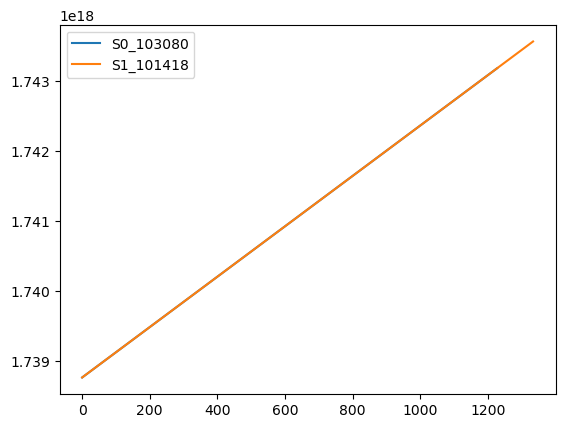

In [15]:
print(waves_S0_103080['Time'])
plt.plot(waves_S0_103080['Time'], label='S0_103080')
plt.plot(waves_S1_101418['Time'], label='S1_101418')
plt.legend()


In [16]:
#Function to convert unix timestamp in ns to regular datetime in UTC
def unix_ns_to_datetime(unix_ns_array):
    dates = []
    for date in unix_ns_array:
        seconds = date // 1_000_000_000
        nanoseconds = date % 1_000_000_000
        python_datetime = datetime.datetime.utcfromtimestamp(seconds) + datetime.timedelta(microseconds=nanoseconds / 1000)
        dates.append(python_datetime)
    return dates

In [17]:
#Applying the function to convert for datetime
unix_ns_array = waves_S0_103080["Time"]
waves_S0_103080["Datetime"] = unix_ns_to_datetime(unix_ns_array[0].values)


unix_ns_array = waves_S1_101418["Time"]
waves_S1_101418["Datetime"] = unix_ns_to_datetime(unix_ns_array[0].values)

In [18]:
#defining the start and end of the data
starttime = pd.to_datetime("2025-02-04 19:10:00", format = '%Y-%m-%d %H:%M:%S') #For deployment 3, S0 was deployed at 3 pm EDT so 7 pm UTC
endtime = pd.to_datetime("2025-03-28 11:30:00", format = '%Y-%m-%d %H:%M:%S') #S0 retrieved at 11 am EDT so 3 pm UTC

**Mean Period**

The mean wave period has units of seconds. It is recorded as the average of the ensemble wave periods for each chunk.  NOTE: We have a large gap in data here and need to look into why

In [9]:
print(waves_S0_103080['GroupSpeed'].iloc[70:80])

           0
70  1.742656
71  1.739307
72  1.737150
73  1.736644
74  1.737565
75  1.740548
76  1.744759
77  1.748848
78  1.751074
79  1.751364


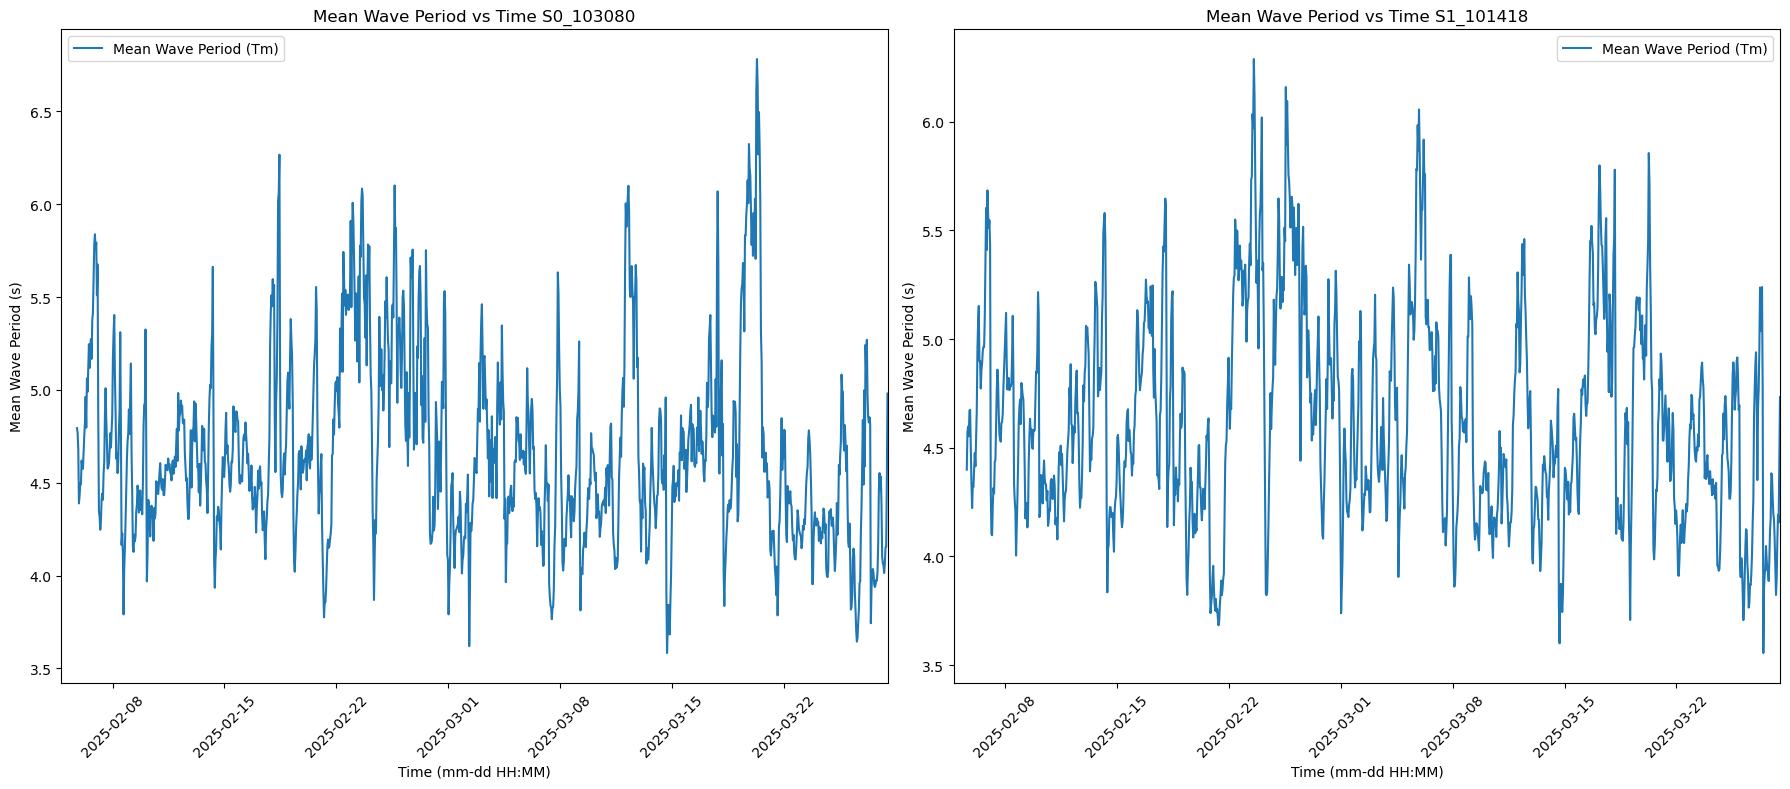

In [19]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanPeriod"], label="Mean Wave Period (Tm)")
# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time S0_103080")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(waves_S1_101418["Datetime"], waves_S1_101418["MeanPeriod"], label="Mean Wave Period (Tm)")
# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time S1_101418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

**Significant Wave Height**

The significant wave height has units of meters.

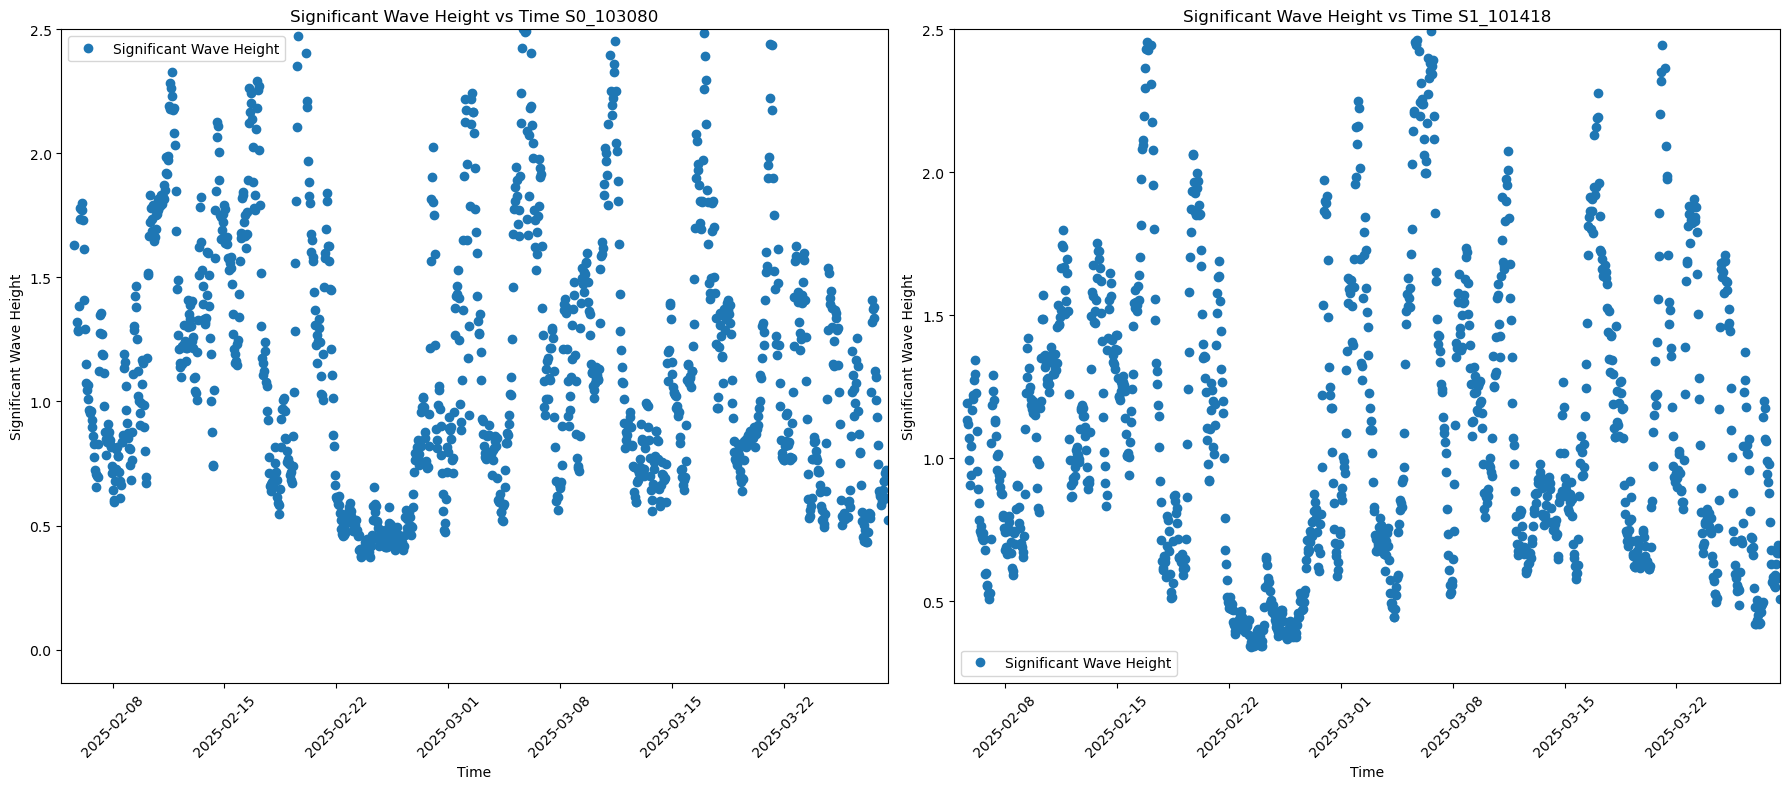

In [20]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(waves_S0_103080["Datetime"], waves_S0_103080["SignificantWaveHeight"], label="Significant Wave Height",marker='o',linestyle='')

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height")
plt.title("Significant Wave Height vs Time S0_103080")
plt.xlim(starttime, endtime)
plt.ylim(top=2.5)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(waves_S1_101418["Datetime"], waves_S1_101418["SignificantWaveHeight"], label="Significant Wave Height",marker='o',linestyle='')

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height")
plt.title("Significant Wave Height vs Time S1_101418")
plt.xlim(starttime, endtime)
plt.ylim(top=2.5)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)


plt.show()

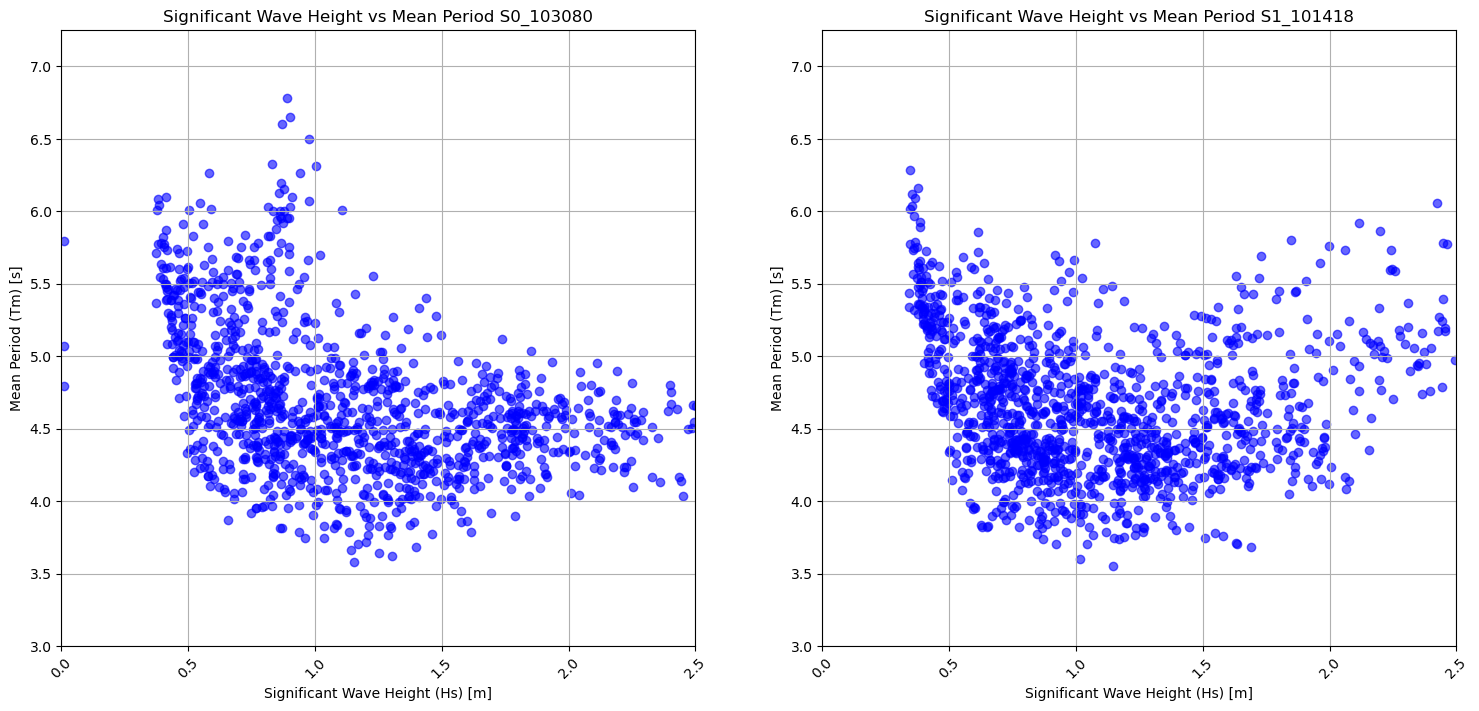

In [22]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
# Plot Mean Wave Period vs Significant wave height
fig=plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period S0_103080')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.xlim(0,2.5)
plt.ylim(3,7.25)
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period S1_101418')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.xlim(0,2.5)
plt.ylim(3,7.25)
plt.grid(True)

plt.show()

**Group Wave Speed**

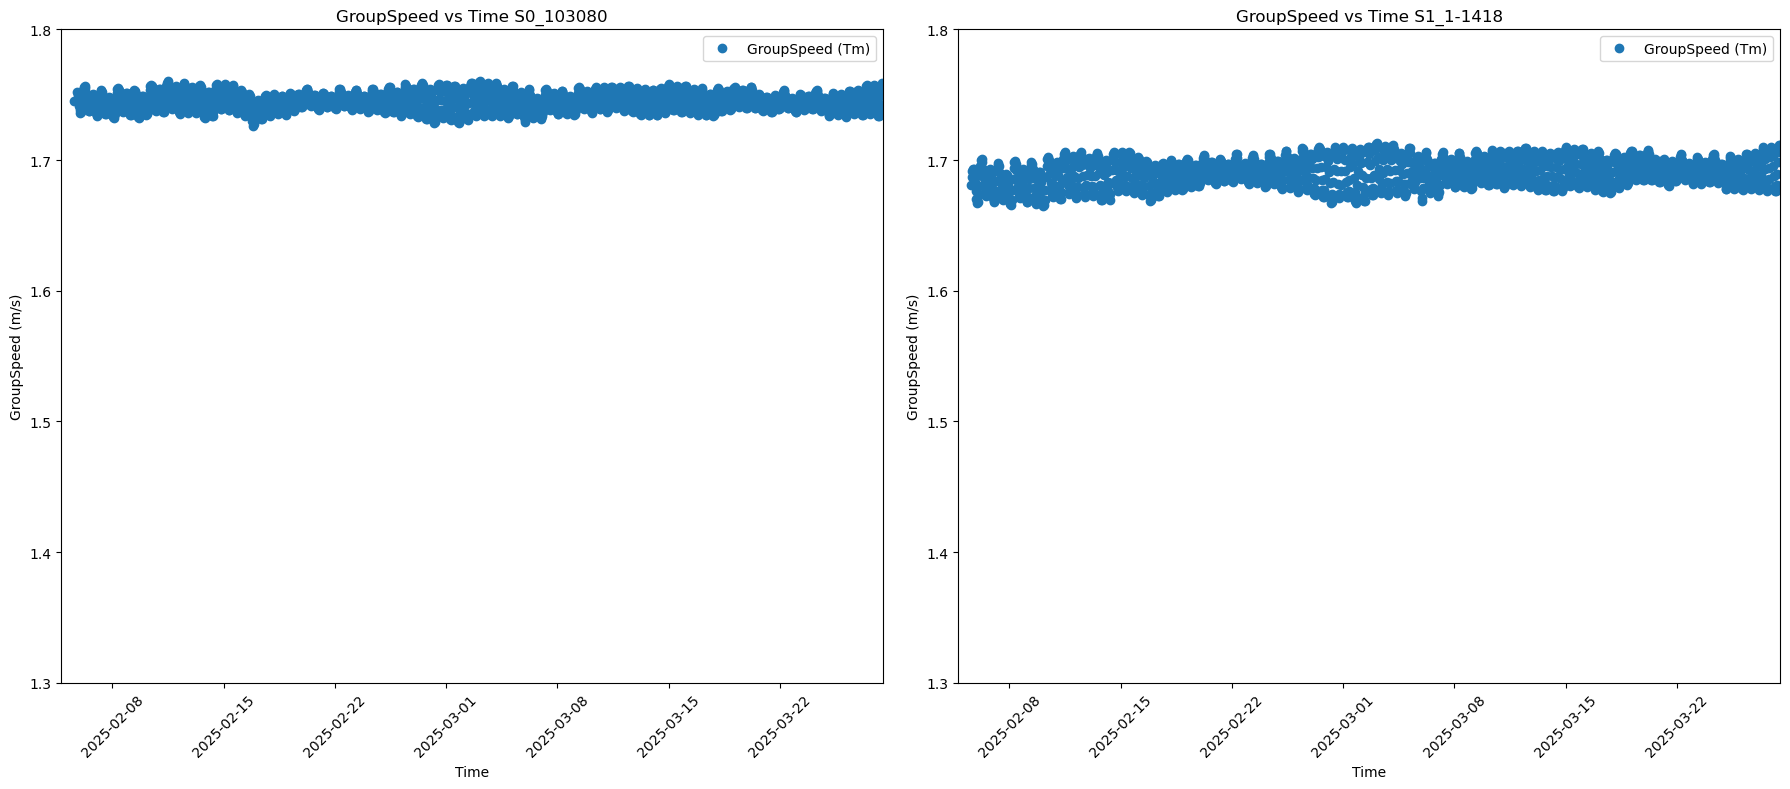

In [23]:
# Plot Group Wave Speed vs Time
fig=plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(waves_S0_103080["Datetime"], waves_S0_103080["GroupSpeed"], label="GroupSpeed (Tm)",marker='o',linestyle='')

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time S0_103080")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.ylim(1.3,1.8)
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(waves_S1_101418["Datetime"], waves_S1_101418["GroupSpeed"], label="GroupSpeed (Tm)",marker='o',linestyle='')

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time S1_1-1418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.ylim(1.3,1.8)
plt.xticks(rotation=45)

plt.show()

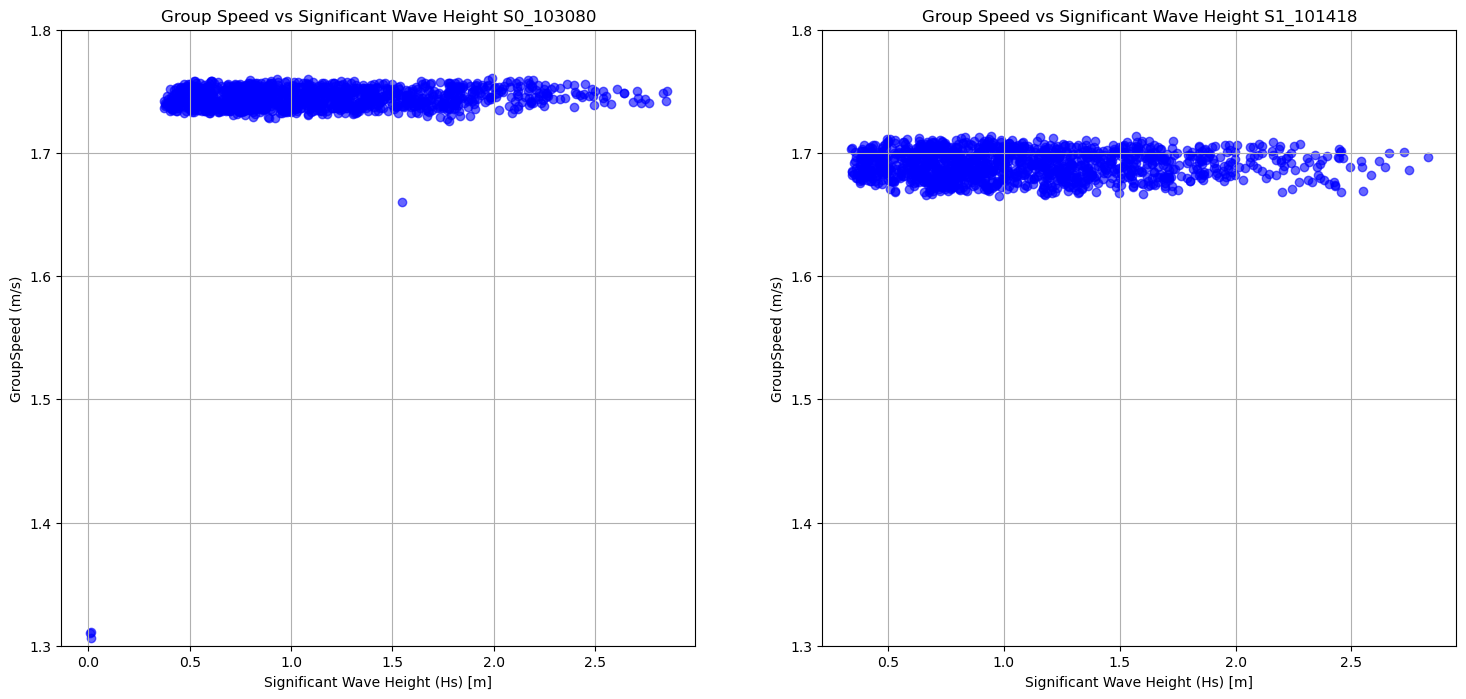

In [24]:
#Look at correlation between wave height and wave group speed
fig=plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height S0_103080')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.ylim(1.3,1.8)
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height S1_101418')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.ylim(1.3,1.8)
plt.grid(True)
plt.show()

**Wave Direction and Spread**

The wave direction contains the average direction of wave groups and the spread of this measurement. The direction is measured in degrees from North, i.e. East = 90, South = 180, West = 270, North = 0 or 360. The spread refers to the deviation in degrees that the wave packets may travel in from the mean direction. So a direction of 90 and a spread of 45 means you would expect the wave packets to be traveling on average due east with parts of the wave packet propogating from ENE to ESE.

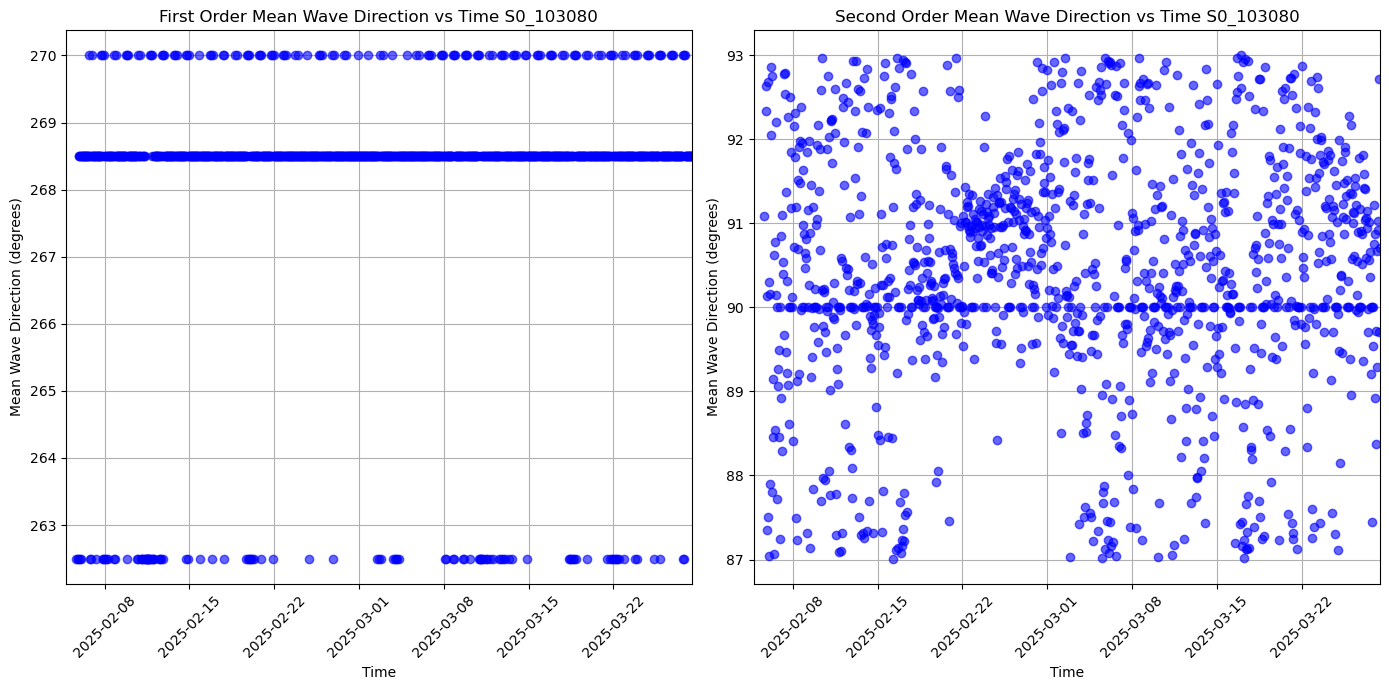

In [25]:
#Code to compare first and second order mean wave direction 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanDirection1"], 'o', linestyle='none', c='blue', alpha=0.6)
ax1.set_title('First Order Mean Wave Direction vs Time S0_103080')
ax2.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanDirection2"], 'o', linestyle='none', c='blue', alpha=0.6)
ax2.set_title('Second Order Mean Wave Direction vs Time S0_103080')
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean Wave Direction (degrees)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()

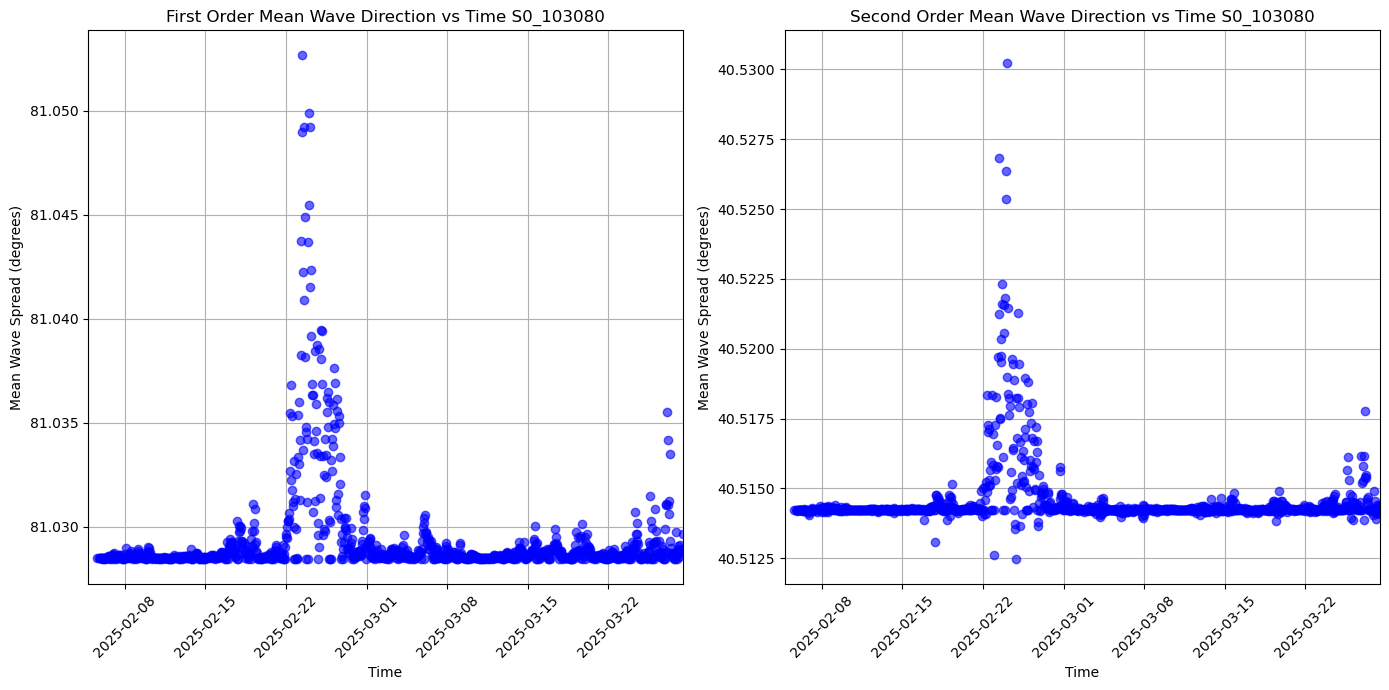

In [26]:
#This compares the first and second order spreads 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanSpread1"], 'o', linestyle='none', c='blue', alpha=0.6)
ax1.set_title('First Order Mean Wave Direction vs Time S0_103080')
ax2.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanSpread2"], 'o', linestyle='none', c='blue', alpha=0.6)
ax2.set_title('Second Order Mean Wave Direction vs Time S0_103080')
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean Wave Spread (degrees)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()    

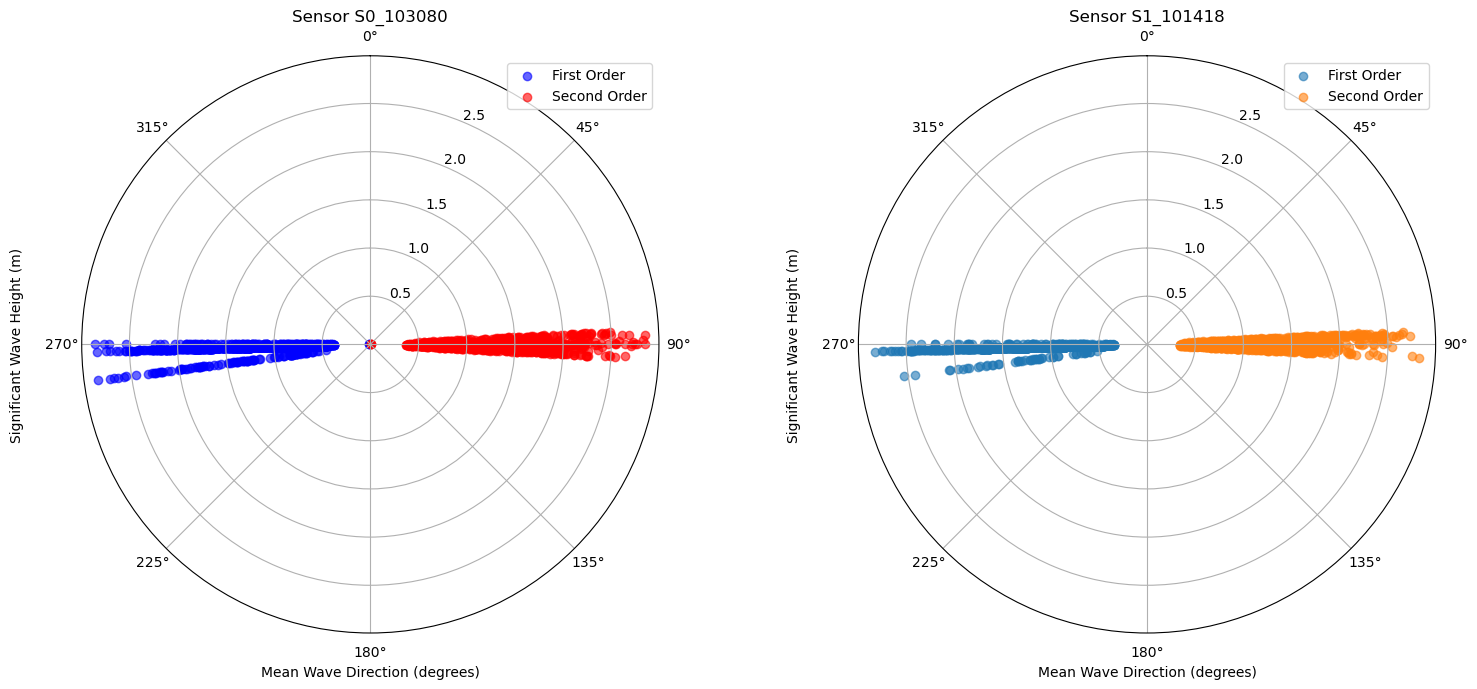

In [27]:
#Create a polar plot of wave direction with signficant wave height as the color to show the intensity of the waves
#Use the spread of the wave direction to show the variability of the waves
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16, 7),sharey=True)
# Plotting the wave direction
ax1.scatter(np.radians(waves_S0_103080['MeanDirection1']),waves_S0_103080['SignificantWaveHeight'] ,c = 'blue', alpha=0.6, label='First Order')
ax1.scatter(np.radians(waves_S0_103080['MeanDirection2']),waves_S0_103080['SignificantWaveHeight'] ,c = 'red', alpha=0.6, label='Second Order')
ax1.set_title('Sensor S0_103080')
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax2.scatter(np.radians(waves_S1_101418['MeanDirection1']) ,waves_S1_101418['SignificantWaveHeight'] , alpha=0.6, label='First Order')
ax2.scatter(np.radians(waves_S1_101418['MeanDirection2']) ,waves_S1_101418['SignificantWaveHeight'] , alpha=0.6, label='Second Order')
for ax in (ax1, ax2):
    ax.legend(loc='upper right')   
    ax.set_theta_direction(-1)  # Set the direction of the angle to be clockwise
    ax.set_theta_zero_location('N')  # Set the zero angle to the top
    ax.set_xlabel('Mean Wave Direction (degrees)')
    ax.set_ylabel('Significant Wave Height (m)')
plt.tight_layout()
ax2.set_title('Sensor S1_101418')
ax2.yaxis.set_label_coords(-0.1, 0.5)

**Depth Averaged Current Velocity**

The Depth Averaged Current Velocity returns the average magnitude of the current across all depths in m/s.

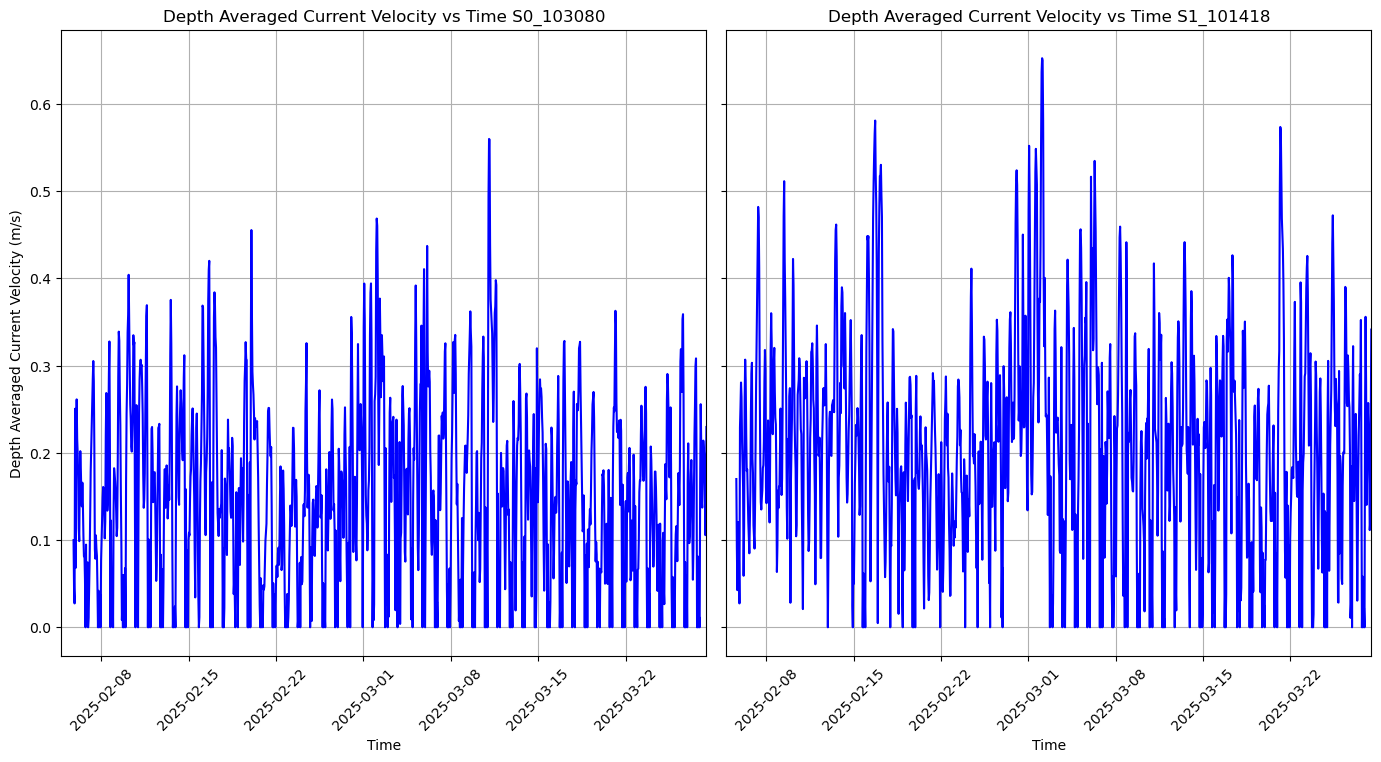

In [28]:
#This code plots the Depth Averaged Current Velocity vs Time for both sensors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
ax1.plot(waves_S0_103080["Datetime"], waves_S0_103080['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax1.set_title('Depth Averaged Current Velocity vs Time S0_103080')
ax1.set_ylabel('Depth Averaged Current Velocity (m/s)')
ax2.plot(waves_S1_101418["Datetime"], waves_S1_101418['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax2.set_title('Depth Averaged Current Velocity vs Time S1_101418')
plt.tight_layout()
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    #ax.set_ylabel('Depth Averaged Current Velocity (m/s)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=45)

**Depth Averaged Current Direction**

This returns the average direction of current flow across all depths in degrees, in cases with lots of turbulence this may not be an accurate way to visualize this.

Text(0.5, 1.0, 'Sensor S1_101418')

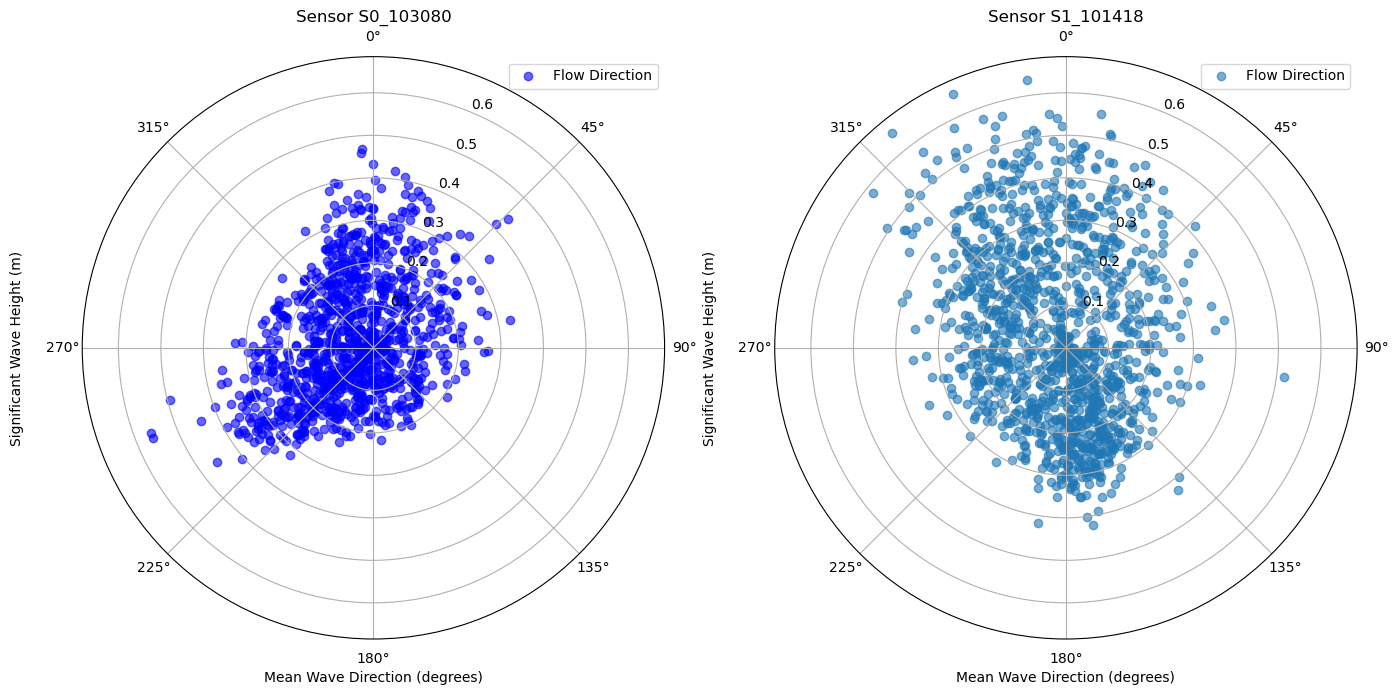

In [29]:
#Create a polar plot of flow direciton with average flow velocity to show the intensity of the flow
#Use the spread of the wave direction to show the variability of the waves
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 7),sharey=True)
# Plotting the wave direction
ax1.scatter(np.radians(waves_S0_103080['DepthAveragedFlowDirection']),waves_S0_103080['DepthAveragedCurrentVelocity'] ,c = 'blue', alpha=0.6, label='Flow Direction')
ax1.set_title('Sensor S0_103080')
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax2.scatter(np.radians(waves_S1_101418['DepthAveragedFlowDirection']) ,waves_S1_101418['DepthAveragedCurrentVelocity'] , alpha=0.6, label='Flow Direction')
ax2.yaxis.set_label_coords(-0.1, 0.5)
for ax in (ax1, ax2):
    ax.legend(loc='upper right')   
    ax.set_theta_direction(-1)  # Set the direction of the angle to be clockwise
    ax.set_theta_zero_location('N')  # Set the zero angle to the top
    ax.set_xlabel('Mean Wave Direction (degrees)')
    ax.set_ylabel('Significant Wave Height (m)')
plt.tight_layout()
ax2.set_title('Sensor S1_101418')

**Energy Spectrum**

The energy spectrum was calculated per each time step of the data collection, and is represented by the variable PressureSpectra. Contrary to the past variables we have calculated and visualizzed, the energy spectrum is in the frequency domain, rather than in the time domain. However, there is an energy spectrum for each time step, so we need to use a spectrogram to best visualize how the energy is changing at each frequency over time.

In [30]:
df=waves_S0_103080['PressureSpectra']
df=df.iloc[:,:-1]
print(df)

              0           1           2          3          4          5    \
0        0.161298    0.048453    0.023536   0.012296   0.006778   0.005495   
1             NaN         NaN         NaN        NaN        NaN        NaN   
2             NaN         NaN         NaN        NaN        NaN        NaN   
3             NaN         NaN         NaN        NaN        NaN        NaN   
4        0.024975    0.007766    0.003878   0.002079   0.002314   0.002176   
...           ...         ...         ...        ...        ...        ...   
1223     0.464068    0.150212    0.061520   0.027250   0.016814   0.011782   
1224  1346.845358  348.840883  132.199872  57.810840  31.922515  19.180413   
1225     0.000561    0.000245    0.000140   0.000070   0.000040   0.000034   
1226     0.000183    0.000090    0.000070   0.000054   0.000032   0.000034   
1227     0.079026    0.017056    0.005879   0.002331   0.001513   0.001087   

            6         7         8         9    ...       159   

In [31]:
freq_nonan=waves_S0_103080['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting -
print(fmax)

0.24609375


/var/folders/q5/f29tpv495_l1nlg9kcr2kl0w0000gx/T/ipykernel_96940/1060598064.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting -


In [32]:
# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S0_103080['Datetime'],freq_nonan)
z=df

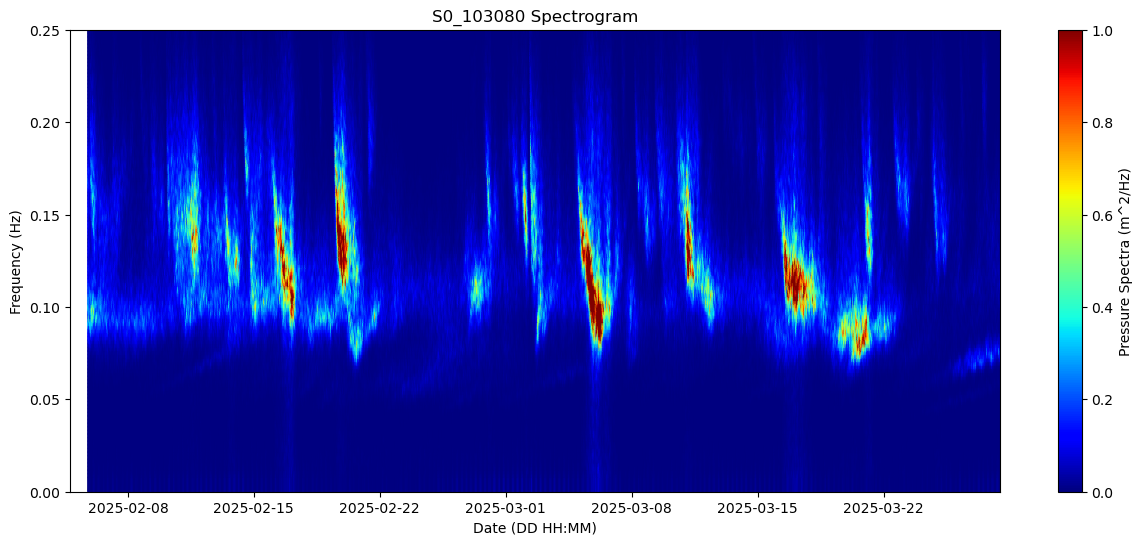

In [33]:
# Plot Energy Spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=0.25)
plt.xlim(starttime,endtime)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Frequency (Hz)")
plt.title('S0_103080 Spectrogram')
im1=plt.colorbar()
im1.ax.set_ylabel("Pressure Spectra (m^2/Hz)")
plt.show()

In [34]:
df=waves_S1_101418['PressureSpectra']
df=df.iloc[:,:-1]

In [35]:
freq_nonan=waves_S1_101418['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting
print(fmax)

0.24609375


/var/folders/q5/f29tpv495_l1nlg9kcr2kl0w0000gx/T/ipykernel_96940/134043482.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting


In [36]:
# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S1_101418['Datetime'],freq_nonan)
z=df

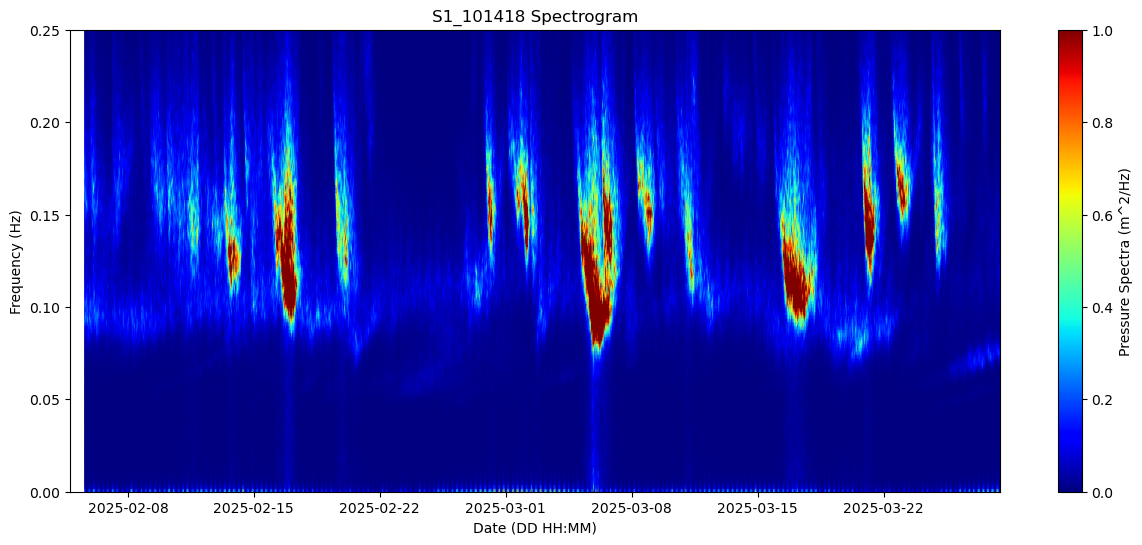

In [37]:
# Plot energy spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=0.25)
plt.xlim(starttime,endtime)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Frequency (Hz)")
plt.title('S1_101418 Spectrogram')
im1=plt.colorbar()
im1.ax.set_ylabel("Pressure Spectra (m^2/Hz)")
plt.show()

**Data Comparison**

We can compare our data to that collected by the Coastal Ocean Research and Monitoring Program (CORMP). There is SOFAR spotter wave buoy located east of Bald Head Island at 33.8684 N 77.9396 W, and will be denoted at BHI_E. This is further onshore than where our ADCPs were recording data, however will still serve as valid comparison. There is another bouy located just outside of the shoals at 33.721 N 78.015 W, owned by the U.S. Army Corps of Engineers. This buoy is closer to lander S0 and S1, at a water depth of 13 m and will be denoted as USACE_41108.

In [39]:
# Read in BHI-E Data
BHI_E_path=r"/Volumes/kanarde/BOEM/deployment_3/BulkStats/CORMP_data/data_BHI_E.csv"
BHI_E_data=pd.read_csv(BHI_E_path,skiprows=10)

In [40]:
## Assign variables for BHI-E buoy
Bdf={}
Bdf["BTime"]=BHI_E_data['Time (America/New_York)']
Bdf["BSigWaveHeight"]=BHI_E_data['BHI-E Significant wave height (ft)']*0.3048 # convert from feet to meters
Bdf["BMeanPeriod"]=BHI_E_data['BHI-E Mean wave period (s)']
Bdf["BMeabWaveDirection"]=BHI_E_data['BHI-E Mean wave direction (deg N)']


In [41]:
# convert to datetime format
Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])

start_date = '2025-02-04'
end_date = '2025-03-28'

# Convert start and end dates to datetime format
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the data based on the date range
filtered_Bdf = {key: value[(Bdf["BTime"] >= start_date) & (Bdf["BTime"] <= end_date)] for key, value in Bdf.items()}

Bdf=filtered_Bdf

/var/folders/q5/f29tpv495_l1nlg9kcr2kl0w0000gx/T/ipykernel_96940/1420876437.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])


In [42]:
# read in USACE data
USACEpath=r"/Volumes/kanarde/BOEM/deployment_1/BulkStats/CORMP_data/41108h2024.txt"
df = pd.read_csv(USACEpath, delim_whitespace=True, header=1)

In [43]:
# convert time
df.rename(columns={'#yr': 'yr'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['yr'].astype(str) + '-' +
                                 df['mo'].astype(str).str.zfill(2) + '-' +
                                 df['dy'].astype(str).str.zfill(2) + ' ' +
                                 df['hr'].astype(str).str.zfill(2) + ':' +
                                 df['mn'].astype(str).str.zfill(2))

In [44]:
# Filter rows based on the date range
filtered_df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
USACEdata=filtered_df
UStime=filtered_df['Datetime']

In [45]:
# assign variables for USACE buoy
USSigWaveHeight=USACEdata["m"]
USMeanPeriod=USACEdata["sec.1"]
USMeanWaveDirection=USACEdata["degT.1"]

Let's compare our data to that collected during the same time period through the CORMP buoy, starting with mean wave period.

In [46]:
# Define custom dates for the x-ticks
custom_xticks = [
    "02/04/25","02/10/25", "02/16/25", "02/22/25", "02/28/25", "03/05/25", "03/11/25", "03/17/25","03/23/25","03/28/25"
]
# Convert these dates to datetime format
custom_xticks = pd.to_datetime(custom_xticks, format='%m/%d/%y')

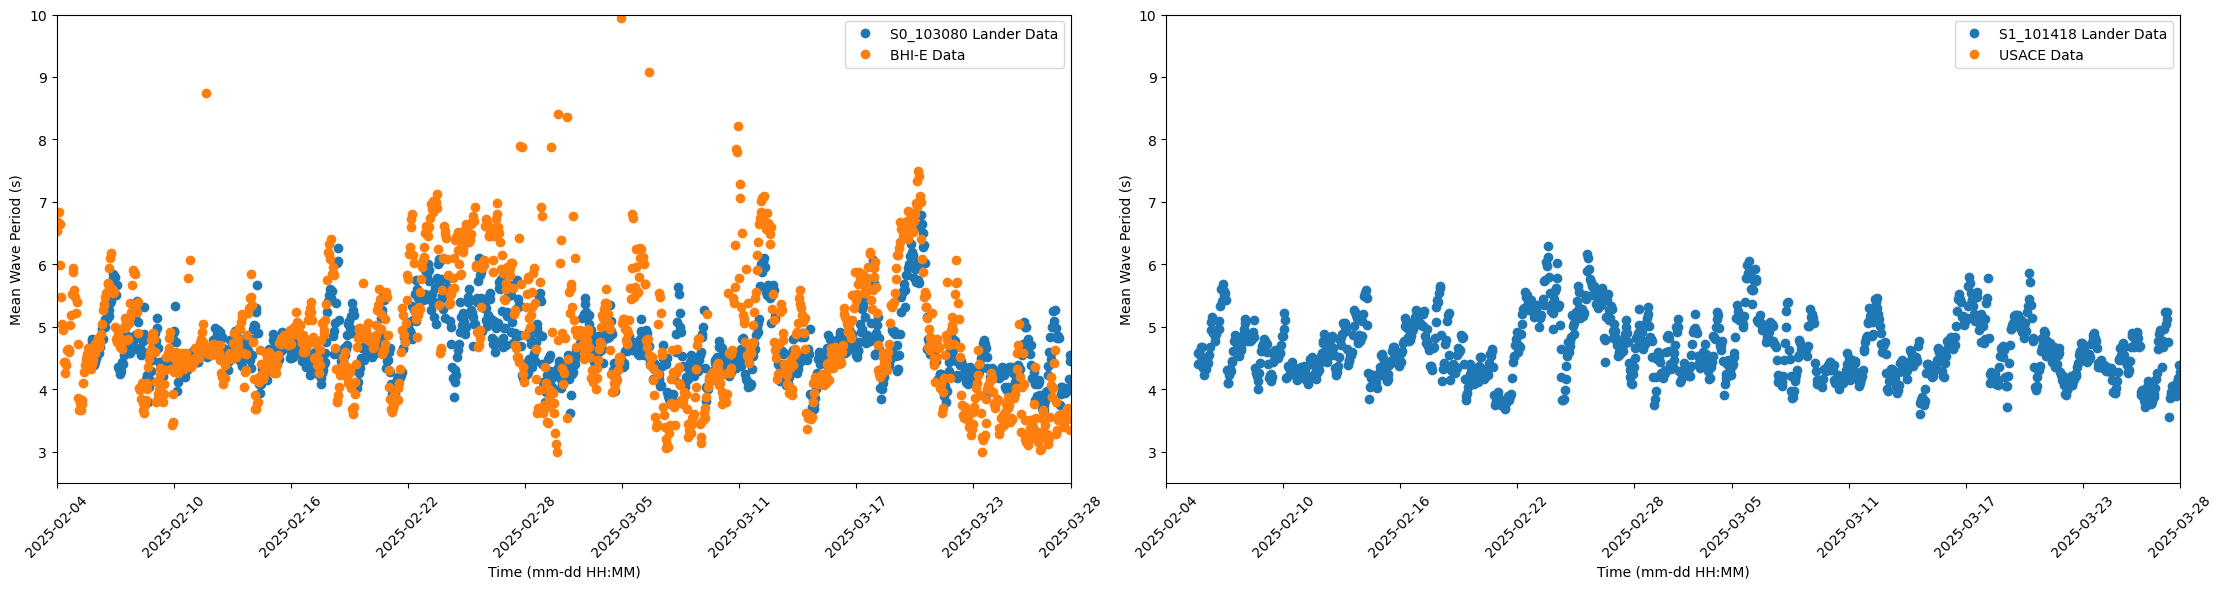

In [47]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanPeriod"], label="S0_103080 Lander Data",marker='o',linestyle='')
plt.plot(Bdf["BTime"], Bdf["BMeanPeriod"], label="BHI-E Data",marker='o',linestyle='')

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.ylim(2.5,10)
plt.xlim(start_date,end_date)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,2,2)
plt.plot(waves_S1_101418["Datetime"], waves_S1_101418["MeanPeriod"], label="S1_101418 Lander Data",marker='o',linestyle='')
plt.plot(UStime, USMeanPeriod, label="USACE Data",marker='o',linestyle='')

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.ylim(2.5,10)
plt.xlim(start_date,end_date)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)


plt.show()

We can also compare our calculated significant wave heights with that of the offshore buoys.

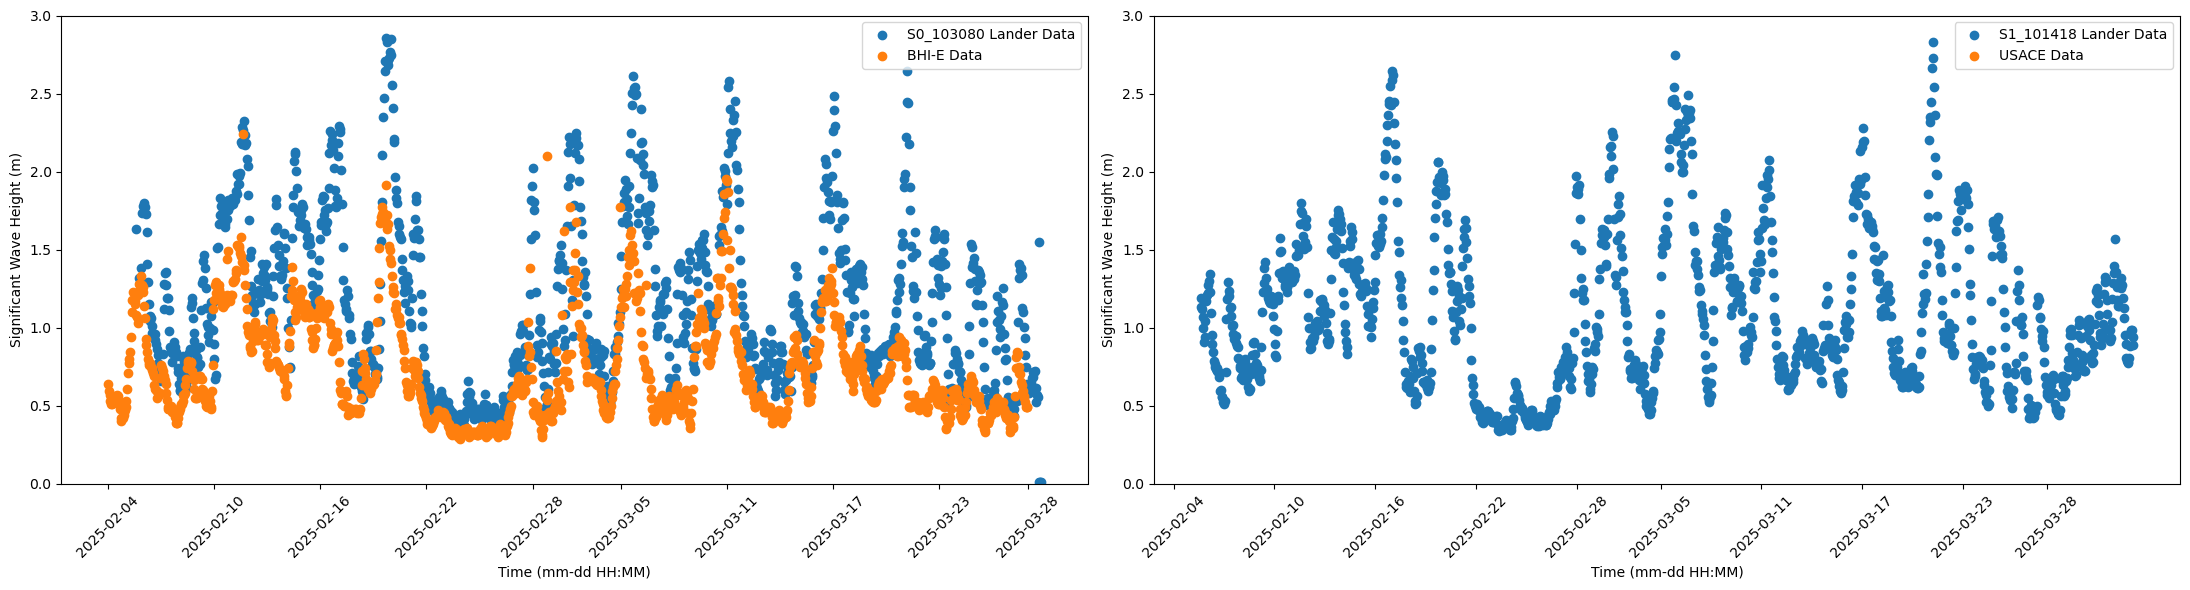

In [48]:
# Plot Significant Wave Height vs Time
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080["Datetime"], waves_S0_103080['SignificantWaveHeight'], label="S0_103080 Lander Data")
plt.scatter(Bdf["BTime"], Bdf["BSigWaveHeight"], label="BHI-E Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Significant Wave Height (m)")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418["Datetime"], waves_S1_101418['SignificantWaveHeight'], label="S1_101418 Lander Data")
plt.scatter(UStime, USSigWaveHeight, label="USACE Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Significant Wave Height (m)")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)


plt.show()

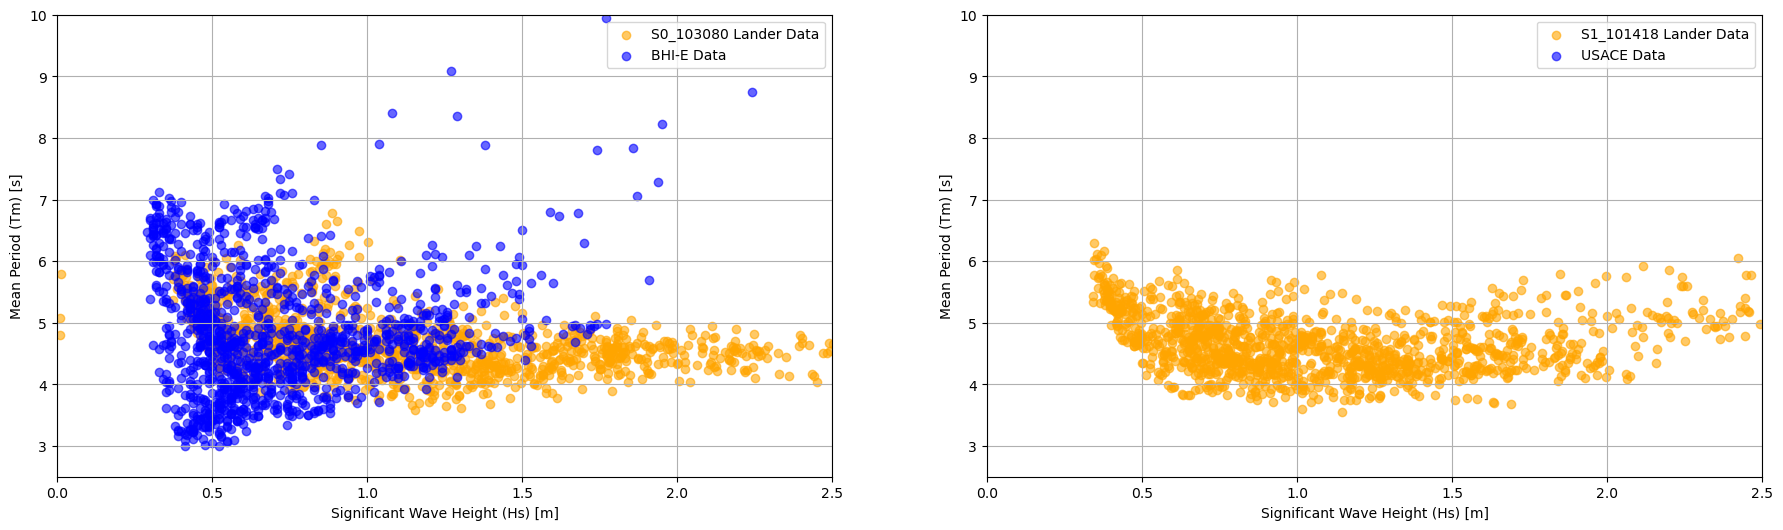

In [49]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['MeanPeriod'], c='orange', alpha=0.6, label="S0_103080 Lander Data")
plt.scatter(Bdf['BSigWaveHeight'],Bdf['BMeanPeriod'], c='blue', alpha=0.6, label="BHI-E Data")

# Formatting
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['MeanPeriod'], c='orange', alpha=0.6, label="S1_101418 Lander Data")
plt.scatter(USSigWaveHeight,USMeanPeriod, c='blue', alpha=0.6, label="USACE Data")

# Formatting
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.legend()
plt.grid(True)


plt.show()